In [1]:
import os
import time
import copy

import cv2
import random
import numpy as np
import pandas as pd

# pytorch utility imports
import torch

# neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import datasets
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.models as models
from tqdm.notebook import tqdm

from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a specific seed value, you can change this to any integer
set_seed(69)

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device('cpu')
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device('cuda')

CUDA is available!  Training on GPU ...


In [4]:
# Data Set Configurations
NUM_WORKERS = 2
BATCH_SIZE = 6

DATA_DIR = r"F:\nuck\data\ki67\ki67\class_dataset"

In [5]:
## Defining Transforms
# convert data to torch.FloatTensor
# augment train and validation dataset with RandomRotation
train_transform = transforms.Compose([
    transforms.Resize(512, antialias=True),          # 調整大小
    transforms.RandomResizedCrop(400),              # 隨機裁剪並調整為400x400
    transforms.RandomHorizontalFlip(),              # 隨機水平翻轉
    transforms.RandomVerticalFlip(),                # 隨機垂直翻轉
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 顏色抖動
    transforms.RandomRotation(10),                  # 隨機旋轉±10度
    transforms.RandomGrayscale(p=0.1),              # 以10%的概率轉換為灰度圖像
    transforms.ToTensor(),                          # 轉換為Tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.400, 0.225]),    # 正規化
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(400, antialias=True),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.400, 0.225])
    ])

full_dataset = ImageFolder(root=DATA_DIR,
                          transform=test_transform)

## Split dataset into Train, Validation and Test Sets
test_dataset, validation_dataset, train_dataset = random_split(full_dataset, [0.1, 0.2, 0.7])


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS)

val_loader = torch.utils.data.DataLoader(validation_dataset, 
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          ) 

In [6]:
class_to_idx = full_dataset.class_to_idx
idx_to_class = {idx : label for label, idx in full_dataset.class_to_idx.items()}

idx_to_class

{0: 'in_tumor', 1: 'not_tumor'}

In [7]:
print(
    f"Shapes after splitting:\n\nTrain: {len(train_dataset)}\
      \nValidation: {len(validation_dataset)}\
      \nTest: {len(test_dataset)}\n\n\
      \nFullDataset: {len(full_dataset)}"
)

Shapes after splitting:

Train: 280      
Validation: 80      
Test: 40

      
FullDataset: 400


In [8]:
for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        break

Epoch: 1 | Batch index: 0 | Batch size: 6
Epoch: 2 | Batch index: 0 | Batch size: 6


In [9]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([6, 3, 400, 400])
Image label dimensions: torch.Size([6])


In [10]:
labels_df = pd.DataFrame(full_dataset.targets, columns=["Labels"]).replace(idx_to_class)


labels_df.head()

,Labels
0,in_tumor
1,in_tumor
2,in_tumor
3,in_tumor
4,in_tumor


In [11]:
import plotly.express as px

# Class distribution for full dataset
fig = px.bar(labels_df.groupby(["Labels"]).size().reset_index(name='counts'), x="Labels", y="counts", title="Class distribution - Full Dataset")
fig.show()


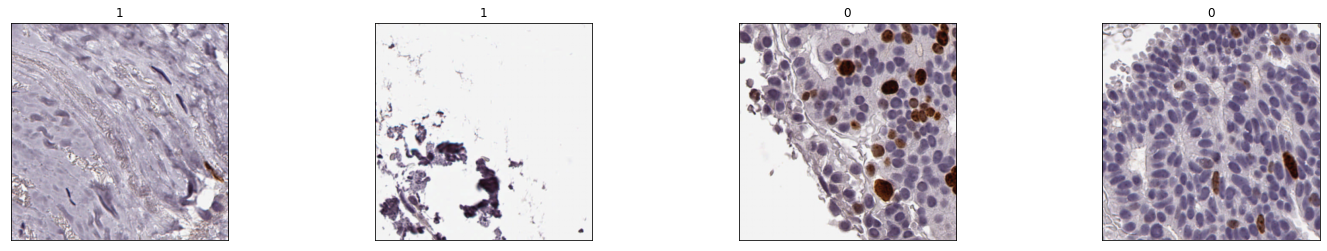

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels  = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx + 1, xticks = [], yticks = [])
    ax.imshow(images[idx].T)
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

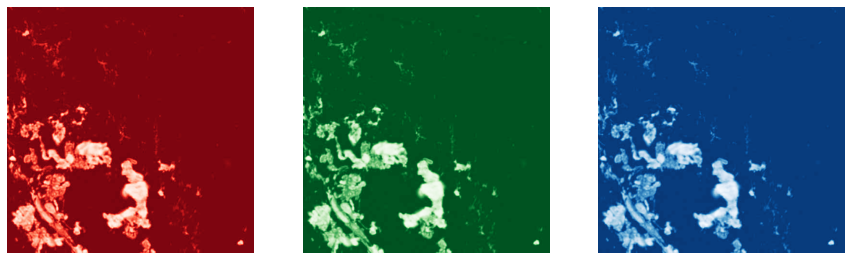

In [13]:
img = images[1].T
colours = ["Reds", "Greens", "Blues"]
n_channels = img.shape[-1]

f, axarr = plt.subplots(1,3, figsize=(15, 15))

for i in range(n_channels):
    
    axarr[i].imshow(img[:, :, i], cmap=colours[i])
    axarr[i].axis("off")


In [14]:
################## Model ###############
########################################

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dropout_prob=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob is not None else None
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        if self.dropout is not None:
            out = self.dropout(out)
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, grayscale=False, dropout_prob=None):
        super(ResNet, self).__init__()
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dropout_prob=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, dropout_prob=dropout_prob))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        # probas = F.softmax(logits, dim=1)

        return logits #, probas




In [15]:
def resnet50(num_classes=1000, grayscale=False, dropout_prob=None):
    """Constructs a ResNet-50 model."""
    model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, grayscale=grayscale, dropout_prob=dropout_prob)
    return model

def resnet101(num_classes=1000, grayscale=False, dropout_prob=None):
    """Constructs a ResNet-101 model."""
    model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, grayscale=grayscale, dropout_prob=dropout_prob)
    return model

In [16]:
# 第二種套件匯入

# import torchvision.models as models
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # 根據類別數目調整輸出層
# model = model.to(DEVICE)

In [17]:
'''
import torch
import torchvision.models as models

# TESTING IF THE MODEL IS WORKING CORRECTLY
# model_test = resnet50(TEST_N_CLASSES, dropout_prob=0.2).to(DEVICE)


model_test = models.resnet50(pretrained=True)
model_test = model_test.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, 2)  # 根據類別數目調整輸出層


TEST_BATCH_SIZE = 16
TEST_INPUT_CHANNELS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_data = torch.randn(TEST_BATCH_SIZE, TEST_INPUT_CHANNELS, 400, 400).to(DEVICE)


model_test = model_test.to(DEVICE)


output = model_test(test_data)
print(output[0].shape)  # 應該輸出 torch.Size([2])
'''

'\nimport torch\nimport torchvision.models as models\n\n# TESTING IF THE MODEL IS WORKING CORRECTLY\n# model_test = resnet50(TEST_N_CLASSES, dropout_prob=0.2).to(DEVICE)\n\n\nmodel_test = models.resnet50(pretrained=True)\nmodel_test = model_test.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))\n\nnum_ftrs = model_test.fc.in_features\nmodel_test.fc = nn.Linear(num_ftrs, 2)  # 根據類別數目調整輸出層\n\n\nTEST_BATCH_SIZE = 16\nTEST_INPUT_CHANNELS = 3\nDEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\ntest_data = torch.randn(TEST_BATCH_SIZE, TEST_INPUT_CHANNELS, 400, 400).to(DEVICE)\n\n\nmodel_test = model_test.to(DEVICE)\n\n\noutput = model_test(test_data)\nprint(output[0].shape)  # 應該輸出 torch.Size([2])\n'

In [18]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(DEVICE)

    train_losses = []
    val_losses = []
    best_val_accuracy = 0.0
    best_model_weights = model.state_dict()
    
    start_time = time.time()
    for epoch in tqdm(range(num_epochs)):
        # Training
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            logits = model(inputs) #, probas
            softmax_output = F.softmax(logits, dim=1)
            loss = criterion(softmax_output, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        average_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                logits = model(inputs) #, probas
                loss = criterion(logits, labels)
                epoch_val_loss += loss.item()

                softmax_output = F.softmax(logits, dim=1)
                _, predicted = torch.max(softmax_output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        average_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        val_accuracy = correct / total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
        # Save the best model weights
        if val_accuracy > best_val_accuracy:
            print("New best model - Saving")
            best_val_accuracy = val_accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(best_model_weights, 'resnet50_weights.pth')

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    print("Training complete. Best Validation Accuracy: {:.4f}".format(best_val_accuracy))

    return train_losses, val_losses, model

In [19]:
N_CLASSES = 2
NUM_EPOCHS = 40
GRAYSCALE = False
INPUT_CHANNELS = 3
LEARNING_RATE = 1e-5

# CONFIGURING MODEL PARAMETES
#第一種自建
# model = resnet50(2, dropout_prob=0.2).to(DEVICE)

# 第二種套件匯入
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

data = torch.randn(INPUT_CHANNELS, 400, 400).to(DEVICE)
input_shape = data.cpu().numpy().shape

# MODEL ARCHITECTURE
print(f"Input Shape: {input_shape}")

summary(model, input_shape)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



Input Shape: (3, 400, 400)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           9,408
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
         MaxPool2d-4         [-1, 64, 100, 100]               0
            Conv2d-5         [-1, 64, 100, 100]           4,096
       BatchNorm2d-6         [-1, 64, 100, 100]             128
              ReLU-7         [-1, 64, 100, 100]               0
            Conv2d-8         [-1, 64, 100, 100]          36,864
       BatchNorm2d-9         [-1, 64, 100, 100]             128
             ReLU-10         [-1, 64, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]          16,384
      BatchNorm2d-12        [-1, 256, 100, 100]             512
           Conv2d-13        [-1, 256, 100, 100]          16,384
      BatchN

In [20]:
train_losses, val_losses, best_model = train_model(model, 
                                                   train_loader, 
                                                   val_loader, 
                                                   criterion, 
                                                   optimizer, 
                                                   num_epochs=NUM_EPOCHS)

  2%|▎         | 1/40 [00:11<07:25, 11.43s/it]

Epoch [1/40], Train Loss: 0.5305, Val Loss: 0.1388, Val Accuracy: 0.9750
Time elapsed: 0.19 min
New best model - Saving


  5%|▌         | 2/40 [00:22<07:05, 11.20s/it]

Epoch [2/40], Train Loss: 0.3785, Val Loss: 0.0350, Val Accuracy: 1.0000
Time elapsed: 0.37 min
New best model - Saving


  8%|▊         | 3/40 [00:33<06:48, 11.05s/it]

Epoch [3/40], Train Loss: 0.3439, Val Loss: 0.0210, Val Accuracy: 1.0000
Time elapsed: 0.56 min


 10%|█         | 4/40 [00:44<06:34, 10.95s/it]

Epoch [4/40], Train Loss: 0.3312, Val Loss: 0.0151, Val Accuracy: 1.0000
Time elapsed: 0.74 min


 12%|█▎        | 5/40 [00:55<06:25, 11.01s/it]

Epoch [5/40], Train Loss: 0.3260, Val Loss: 0.0106, Val Accuracy: 1.0000
Time elapsed: 0.92 min


 15%|█▌        | 6/40 [01:06<06:12, 10.97s/it]

Epoch [6/40], Train Loss: 0.3235, Val Loss: 0.0085, Val Accuracy: 1.0000
Time elapsed: 1.10 min


 18%|█▊        | 7/40 [01:17<06:01, 10.97s/it]

Epoch [7/40], Train Loss: 0.3222, Val Loss: 0.0072, Val Accuracy: 1.0000
Time elapsed: 1.29 min


 20%|██        | 8/40 [01:28<05:50, 10.95s/it]

Epoch [8/40], Train Loss: 0.3214, Val Loss: 0.0062, Val Accuracy: 1.0000
Time elapsed: 1.47 min


 22%|██▎       | 9/40 [01:39<05:40, 10.98s/it]

Epoch [9/40], Train Loss: 0.3209, Val Loss: 0.0055, Val Accuracy: 1.0000
Time elapsed: 1.65 min


 25%|██▌       | 10/40 [01:50<05:29, 10.99s/it]

Epoch [10/40], Train Loss: 0.3205, Val Loss: 0.0049, Val Accuracy: 1.0000
Time elapsed: 1.83 min


 28%|██▊       | 11/40 [02:01<05:18, 10.98s/it]

Epoch [11/40], Train Loss: 0.3202, Val Loss: 0.0046, Val Accuracy: 1.0000
Time elapsed: 2.02 min


 30%|███       | 12/40 [02:12<05:07, 11.00s/it]

Epoch [12/40], Train Loss: 0.3200, Val Loss: 0.0041, Val Accuracy: 1.0000
Time elapsed: 2.20 min


 32%|███▎      | 13/40 [02:23<04:57, 11.01s/it]

Epoch [13/40], Train Loss: 0.3198, Val Loss: 0.0039, Val Accuracy: 1.0000
Time elapsed: 2.39 min


 35%|███▌      | 14/40 [02:34<04:47, 11.05s/it]

Epoch [14/40], Train Loss: 0.3197, Val Loss: 0.0036, Val Accuracy: 1.0000
Time elapsed: 2.57 min


 38%|███▊      | 15/40 [02:45<04:37, 11.11s/it]

Epoch [15/40], Train Loss: 0.3196, Val Loss: 0.0034, Val Accuracy: 1.0000
Time elapsed: 2.76 min


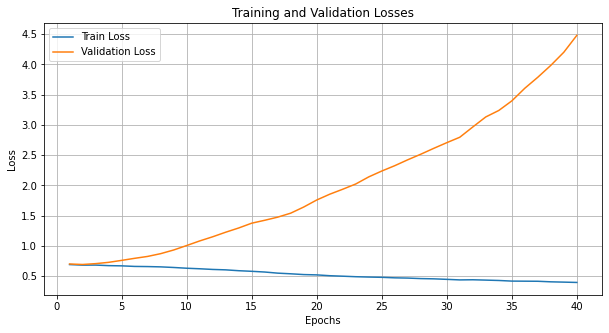

In [ ]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# Call the function to plot
plot_losses(train_losses, val_losses)

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(best_model, test_loader, device=DEVICE)))

Test accuracy: 52.50%


In [ ]:
# Initialize lists to store true labels and predicted labels
all_targets = []
all_predictions = []
class_names = list(class_to_idx.keys())

# Iterate through the entire dataset
for batch_idx, (inputs, labels) in enumerate(test_loader):
    # Making predictions
    model.eval()
    logits, probas = model(inputs.to(DEVICE))
    _, predicted_labels = torch.max(probas, 1)

    all_targets.extend(labels.numpy())
    all_predictions.extend(predicted_labels.cpu().numpy())

all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# Generate classification report for the entire dataset
print("Classification Report:")
print(classification_report(all_targets, all_predictions))

# Generate confusion matrix for the entire dataset
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix using sklearn's plot_confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)


disp.plot(cmap=plt.cm.Blues,values_format='g')


OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 8.00 GiB total capacity; 6.96 GiB already allocated; 0 bytes free; 7.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
for batch_idx, (inputs, labels) in enumerate(val_loader):

    features = inputs
    targets = labels
    break

# Making predictions
model.eval()
logits, probas = model(features.to(DEVICE))
_, predicted_labels = torch.max(probas, 1)

predictions = predicted_labels.cpu().numpy()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))


for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    ax.imshow(features[idx].numpy().T)
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(f"True: {str(labels[idx].item())},\nPredicted: {predictions[idx]}")
    

# Add vertical spacing between subplots
fig.subplots_adjust(hspace=0.5)
plt.show()